In [1]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
!pip install plotly --user
import plotly.express as px
import networkx as nx
import time
import math as math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

In [2]:
#import data
sephora = pd.read_csv('C:/Users/admin/Desktop/labs/sephora_website_dataset.csv')
sephora.head()

id           brand   category                            name  \
0  2218774  Acqua Di Parma  Fragrance  Blu Mediterraneo MINIATURE Set   
1  2044816  Acqua Di Parma    Cologne                         Colonia   
2  1417567  Acqua Di Parma    Perfume                Arancia di Capri   
3  1417617  Acqua Di Parma    Perfume                Mirto di Panarea   
4  2218766  Acqua Di Parma  Fragrance           Colonia Miniature Set   

             size  rating  number_of_reviews  love  price  value_price  ...  \
0  5 x 0.16oz/5mL     4.0                  4  3002   66.0         75.0  ...   
1   0.7 oz/ 20 mL     4.5                 76  2700   66.0         66.0  ...   
2    5 oz/ 148 mL     4.5                 26  2600  180.0        180.0  ...   
3   2.5 oz/ 74 mL     4.5                 23  2900  120.0        120.0  ...   
4  5 x 0.16oz/5mL     3.5                  2   943   72.0         80.0  ...   

  MarketingFlags  MarketingFlags_content  \
0           True             online only   
1           True             online only   
2           True             online only   
3           True             online only   
4           True             online only   

                                             options  \
0                                         no options   
1   - 0.7 oz/ 20 mL  Spray  - 1.7 oz/ 50 mL Eau d...   
2   - 1oz/30mL Eau de Toilette  - 2.5 oz/ 74 mL E...   
3   - 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...   
4                                         no options   

                                             details  \
0  This enchanting set comes in a specially handc...   
1  An elegant timeless scent filled with a fresh-...   
2  Fragrance Family: Fresh Scent Type: Fresh Citr...   
3  Panarea near Sicily is an an island suspended ...   
4  The Colonia Miniature Set comes in an iconic A...   

                                          how_to_use  \
0  Suggested Usage:-Fragrance is intensified by t...   
1                                    no instructions   
2                                    no instructions   
3                                    no instructions   
4  Suggested Usage:-Fragrance is intensified by t...   

                                         ingredients online_only  exclusive  \
0  Arancia di Capri Eau de Toilette: Alcohol Dena...           1          0   
1                                            unknown           1          0   
2  Alcohol Denat.- Water- Fragrance- Limonene- Li...           1          0   
3                                            unknown           1          0   
4  Colonia: Alcohol Denat.- Water- Fragrance- Lim...           1          0   

   limited_edition  limited_time_offer  
0                0                   0  
1                0                   0  
2                0                   0  
3                0                   0  
4                0                   0  

[5 rows x 21 columns]

In [3]:
#add bin column to include price ranges for each product 
#this will be used for later when we graph the network analysis 
bins = [1, 30, 50, 100, 200]
sephora['bin'] = np.searchsorted(bins, sephora['price'].values)
sephora.head()

id           brand   category                            name  \
0  2218774  Acqua Di Parma  Fragrance  Blu Mediterraneo MINIATURE Set   
1  2044816  Acqua Di Parma    Cologne                         Colonia   
2  1417567  Acqua Di Parma    Perfume                Arancia di Capri   
3  1417617  Acqua Di Parma    Perfume                Mirto di Panarea   
4  2218766  Acqua Di Parma  Fragrance           Colonia Miniature Set   

             size  rating  number_of_reviews  love  price  value_price  ...  \
0  5 x 0.16oz/5mL     4.0                  4  3002   66.0         75.0  ...   
1   0.7 oz/ 20 mL     4.5                 76  2700   66.0         66.0  ...   
2    5 oz/ 148 mL     4.5                 26  2600  180.0        180.0  ...   
3   2.5 oz/ 74 mL     4.5                 23  2900  120.0        120.0  ...   
4  5 x 0.16oz/5mL     3.5                  2   943   72.0         80.0  ...   

  MarketingFlags_content                                            options  \
0            online only                                         no options   
1            online only   - 0.7 oz/ 20 mL  Spray  - 1.7 oz/ 50 mL Eau d...   
2            online only   - 1oz/30mL Eau de Toilette  - 2.5 oz/ 74 mL E...   
3            online only   - 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...   
4            online only                                         no options   

                                             details  \
0  This enchanting set comes in a specially handc...   
1  An elegant timeless scent filled with a fresh-...   
2  Fragrance Family: Fresh Scent Type: Fresh Citr...   
3  Panarea near Sicily is an an island suspended ...   
4  The Colonia Miniature Set comes in an iconic A...   

                                          how_to_use  \
0  Suggested Usage:-Fragrance is intensified by t...   
1                                    no instructions   
2                                    no instructions   
3                                    no instructions   
4  Suggested Usage:-Fragrance is intensified by t...   

                                         ingredients online_only exclusive  \
0  Arancia di Capri Eau de Toilette: Alcohol Dena...           1         0   
1                                            unknown           1         0   
2  Alcohol Denat.- Water- Fragrance- Limonene- Li...           1         0   
3                                            unknown           1         0   
4  Colonia: Alcohol Denat.- Water- Fragrance- Lim...           1         0   

   limited_edition  limited_time_offer  bin  
0                0                   0    3  
1                0                   0    3  
2                0                   0    4  
3                0                   0    4  
4                0                   0    3  

[5 rows x 22 columns]

In [4]:
#this is to see how many products are in each bin
s = pd.cut(sephora['price'], bins=bins).value_counts()
s

(1, 30]       3967
(30, 50]      2471
(50, 100]     1885
(100, 200]     668
Name: price, dtype: int64

In [5]:
duplicates = list(sephora.name.value_counts().loc[lambda x: x>1].index)
duplicates

['Blush',
 'Discovery Set',
 'Lip Gloss',
 'Face Mask',
 'Lipstick',
 'The Foundation Brush',
 'Pour Homme',
 'Shea Butter Foot Cream',
 'Color Care Shampoo',
 'Hydrating Shampoo',
 'Conditioner',
 'Treatment Lotion Hydrating Mask',
 'Curl Cream',
 'Cleansing Oil Shampoo',
 'False Eye Lashes',
 'Clear Brow Gel',
 'Grapefruit Candle',
 'Color Care Conditioner',
 'Hydrating Conditioner',
 'Clarifying Serum',
 'Vitamin C Glow Face Mask',
 'Full Conditioner',
 'Volume Shampoo',
 'Volume Conditioner',
 'Clarifying Lotion 2',
 'Leave-In Conditioner',
 'Triple Action Cleansing Water',
 'Matte Bronzer Powder',
 'Hanging Organizer',
 'Liquid Lipstick',
 'La Petite Robe Noire',
 'Full Shampoo',
 'Body Cleanser',
 'Cleanser',
 'Volumizing Mousse',
 'Shave Cream',
 'Dr. Andrew Weil For Origins™ Mega-Mushroom Relief & Resilience Soothing Treatment Lotion',
 'Good Girl Gift Set',
 'Rose Quartz Facial Roller',
 'Pencil Sharpener',
 'Bb. Pret-a-Powder Tres Invisible Dry Shampoo with French Pink Clay',

In [6]:
#remove duplicates
for i, rowi in sephora.iterrows():
    if rowi['name'] in duplicates:
        n = rowi['name']
        j = rowi["id"]
        sephora.at[i, "name"] = str(j) + " " + n
        
duplicates2 = list(sephora.name.value_counts().loc[lambda x: x>1].index)
#print(duplicates2)

for i, rowi in sephora.iterrows():
    if rowi['name'] in duplicates2:
        n = rowi['name']
        j = rowi["rating"]
        sephora.at[i, "name"] = str(j) + " " + n
        
duplicates3 = list(sephora.name.value_counts().loc[lambda x: x>1].index)
print(duplicates3)

[]


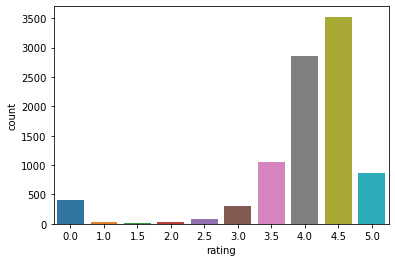

In [7]:
#EDA
#Rating distribution
sns.countplot(x='rating', data=sephora)


[Text(0, 0, 'Perfume'),
 Text(0, 0, 'Moisturizers'),
 Text(0, 0, 'Face Serums'),
 Text(0, 0, 'Value & Gift Sets'),
 Text(0, 0, 'Face Wash & Cleansers'),
 Text(0, 0, 'Face Masks'),
 Text(0, 0, 'Rollerballs & Travel Size'),
 Text(0, 0, 'Hair Styling Products'),
 Text(0, 0, 'Eye Palettes'),
 Text(0, 0, 'Lipstick'),
 Text(0, 0, 'Eye Creams & Treatments')]

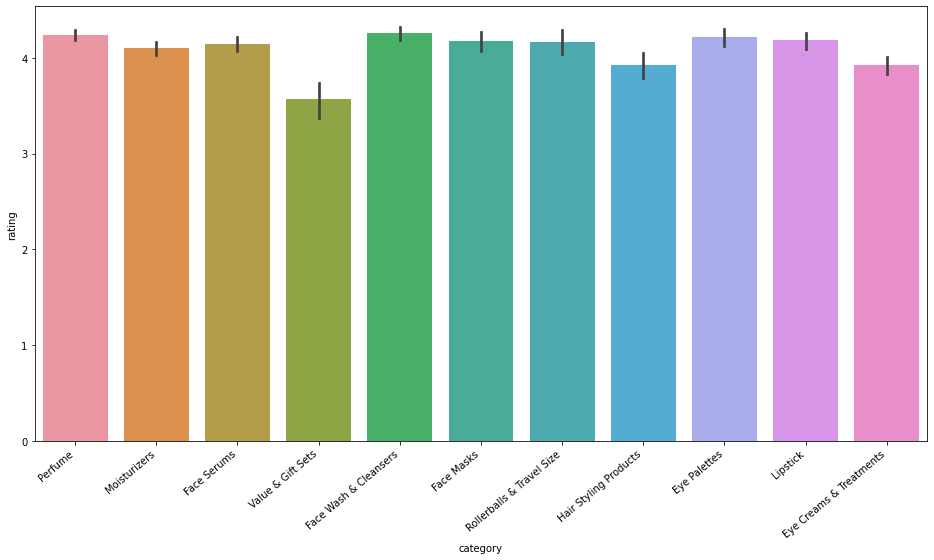

In [8]:
# category with high ratings
plt.figure(figsize=(16,8))
ax= sns.barplot(x='category', y='rating', data=sephora, order=pd.value_counts(sephora['category']).iloc[:11].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

[Text(0, 0, 'Perfume'),
 Text(0, 0, 'Moisturizers'),
 Text(0, 0, 'Face Serums'),
 Text(0, 0, 'Value & Gift Sets'),
 Text(0, 0, 'Face Wash & Cleansers'),
 Text(0, 0, 'Face Masks'),
 Text(0, 0, 'Rollerballs & Travel Size'),
 Text(0, 0, 'Hair Styling Products'),
 Text(0, 0, 'Eye Palettes'),
 Text(0, 0, 'Lipstick'),
 Text(0, 0, 'Eye Creams & Treatments')]

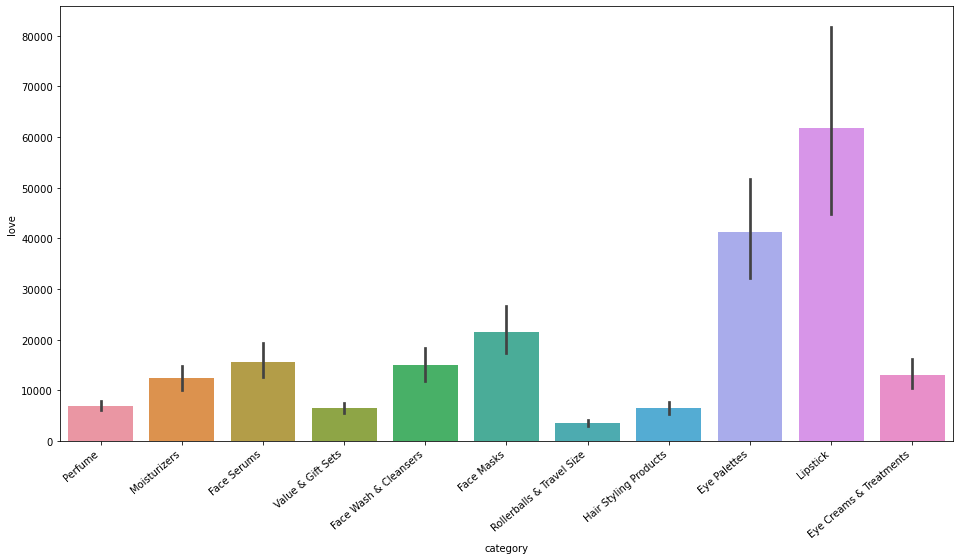

In [9]:
# Most liked category
plt.figure(figsize=(16,8))
ax=sns.barplot(x='category', y='love', data=sephora, order=pd.value_counts(sephora['category']).iloc[:11].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

[Text(0, 0, 'Perfume'),
 Text(0, 0, 'Moisturizers'),
 Text(0, 0, 'Face Serums'),
 Text(0, 0, 'Value & Gift Sets'),
 Text(0, 0, 'Face Wash & Cleansers'),
 Text(0, 0, 'Face Masks'),
 Text(0, 0, 'Rollerballs & Travel Size'),
 Text(0, 0, 'Hair Styling Products'),
 Text(0, 0, 'Eye Palettes'),
 Text(0, 0, 'Lipstick'),
 Text(0, 0, 'Eye Creams & Treatments')]

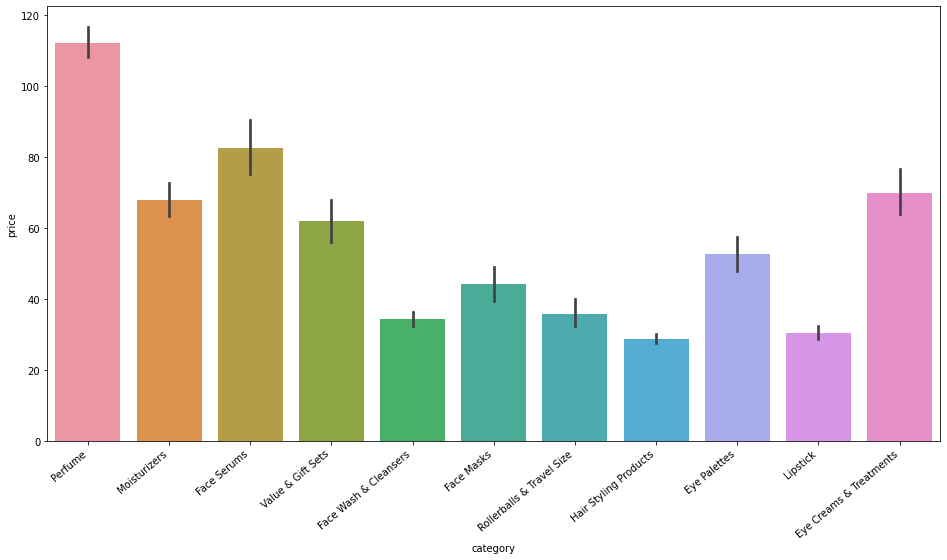

In [10]:
#Price range in each category
plt.figure(figsize=(16,8))
ax=sns.barplot(x='category', y='price', data=sephora, order=pd.value_counts(sephora['category']).iloc[:11].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [11]:
# This is to filter facial skin care products, extracting relevant categories

skincare = ['Moisturizers', 'Face Serums', 'Face Wash & Cleansers', 'Face Masks', 'Eye Creams & Treatments', \
             'Toners', 'Face Oils', 'Face Sunscreen', 'Sheet Masks', 'Facial Peels', 'Skincare', 'Exfoliators' \
            'Face Sets', 'Anti-Aging', 'For Face']

skin = sephora[sephora['category'].isin(skincare)].reset_index()

In [12]:
# clean and tokenize the text in details column: 
def clean_and_tokenize(text):
    # Clean out sentences: Convert to lowercase & remove characters 
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = text.strip('\n')
    # Remove titles
    titles = '|'.join(['what it is', 'skin type', 'skincare concerns', 'formulation', 'highlighted ingredients', \
                      'ingredient callouts', 'what else you need to know', 'clinical results'])
    text = re.sub(titles, "", text)
    # Tokenize into words
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    words = [x for x in tokens if x not in stopwords.words("english")]
    # Remove n's
    words = [x for x in words if x != 'n']
    # Lemmatize, but do not lemmatize 'sls' and 'sles' terms
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) if word not in ['sls', 'sles'] else word for word in words]
    return lemmatized

In [13]:
# Create a set of clean words details
words = clean_and_tokenize(''.join(str(skin['details'].to_list())))

In [14]:
words

['vegan',
 'collagen',
 'treatment',
 'serum',
 'help',
 'restore',
 'skin',
 'natural',
 'bounce',
 'resilience',
 'diminishing',
 'look',
 'fine',
 'line',
 'wrinkle',
 'normal',
 'dry',
 'combination',
 'oily',
 'fine',
 'line',
 'wrinkle',
 'dullness',
 'uneven',
 'texture',
 'loss',
 'firmness',
 'elasticity',
 'lightweight',
 'serum',
 'patented',
 'alguronic',
 'acid',
 'naturally',
 'sourced',
 'sustainably',
 'produced',
 'algae',
 'clinically',
 'shown',
 'visibly',
 'minimize',
 'appearance',
 'fine',
 'line',
 'wrinkle',
 'well',
 'boost',
 'benefit',
 'active',
 'ingredient',
 'exclusive',
 'active',
 'vegan',
 'collagen',
 'high',
 'concentration',
 'vegan',
 'collagen',
 'help',
 'strengthen',
 'condition',
 'skin',
 'visibly',
 'improve',
 'texture',
 'suppleness',
 'microalgae',
 'oil',
 'hydrate',
 'nurture',
 'visibly',
 'restores',
 'skin',
 'radiance',
 'supporting',
 'skin',
 'cell',
 'softer',
 'look',
 'free',
 'sulfate',
 'sls',
 'sles',
 'parabens',
 'formalde

In [15]:
# Dataframe for top frequent words in the descriptions
word10 = pd.Series(words).value_counts().reset_index().\
            rename(columns = {"index":"word", 0:"counts"})

# Filter showing only top 10
topwords = word10[:10]

In [16]:
# Plot the top words
fig = px.bar(x = topwords.word,
             y = topwords.counts,
             labels = {
                 'x' : 'Words',
                 'y' : 'Counts'
             },
             title = 'Most frequent words in product descriptions')

fig.show()

In [17]:
# Dataframe for bigrams
bigrams10 = pd.Series(nltk.ngrams(words, 2)).value_counts().reset_index().rename(columns = {"index":"bigrams", 0:"counts"})
bigrams10['bigrams'] = bigrams10['bigrams'].astype(str)

# Filter only showing top 10
topbigrams = bigrams10[:10]

In [18]:
# Plot the top bigrams
fig = px.bar(x = topbigrams.bigrams,
             y = topbigrams.counts,
             labels = {
                 'x' : 'Bigrams',
                 'y' : 'Counts'
             },
             title = 'Top 10 bigrams found in product descriptions')
fig.show()

In [19]:
# Dataframe for trigrams
trigrams = pd.Series(nltk.ngrams(words, 3)).value_counts().reset_index().rename(columns = {"index":"trigrams", 0:"counts"})
trigrams['trigrams'] = trigrams['trigrams'].astype(str)

# Filter only showing top 10
toptrigrams = trigrams[:10]

In [20]:
# Plot the top trigrams
fig = px.bar(x = toptrigrams.trigrams,
             y = toptrigrams.counts,
             labels = {
                 'x' : 'trigrams',
                 'y' : 'Counts'
             },
             title = 'Top 10 trigrams found in product descriptions')
fig.show()

In [21]:
#TFIDf for details column

text_content = sephora['details']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

In [22]:
# Find similar : get the top_n products with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

In [23]:
# Load the graph by adding nodes and edges

G = nx.Graph(label="name")
start_time = time.time()
for i, rowi in sephora.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    #G.add_node(rowi['name'],key=rowi['id'],label="name",mtype=rowi['category'],rating=rowi['rating'])
    element = rowi['name']
    G.add_node(element,label="PRODUCTS")
    G.add_edge(rowi['name'], element, label="NAME_IN")
    element2 = rowi['category']
    G.add_node(element2,label="CAT")
    G.add_edge(rowi['name'], element2, label="CAT_IN")
    element3 = rowi['brand']
    G.add_node(element3,label="BRAND")
    G.add_edge(rowi['name'], element3, label="BRAND")
    element4 = rowi['ingredients']
    el4 = element4.split("-")
    for j in el4:
         if(j != " please read the ingredient list on the packaging of your product to be sure that the ingredients are appropriate for your personal use."
          and j != "unknown" and j != ""):
            if(j == "Aqua (Water)" or j == " Aqua / Water "):
                j = " Water"
            G.add_node(j,label="INGREDIENTS")
            G.add_edge(rowi['name'], j, label="INGREDIENTS")
            
    element5 = rowi['bin']
    G.add_node(element5,label="BIN")
    G.add_edge(rowi['name'], element5, label="BINS_IN")
    element6 = rowi['online_only']
    G.add_node(element6,label="ONLINE")
    G.add_edge(rowi['name'], element6, label="ONLINE_IN")        
    element7 = rowi['exclusive']
    G.add_node(element7,label="EXCLUSIVE")
    G.add_edge(rowi['name'], element7, label="EXCLUSIVE_IN")       
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['name'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['name'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, sephora['name'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))

 iter 0 -- 0.00798177719116211 seconds --
 iter 1000 -- 23.984471559524536 seconds --
 iter 2000 -- 45.312612533569336 seconds --
 iter 3000 -- 66.47042989730835 seconds --
 iter 4000 -- 87.5900707244873 seconds --
 iter 5000 -- 108.39766716957092 seconds --
 iter 6000 -- 128.96387600898743 seconds --
 iter 7000 -- 150.68669295310974 seconds --
 iter 8000 -- 171.33459734916687 seconds --
 iter 9000 -- 192.43099093437195 seconds --
 finish -- 195.8262424468994 seconds --


In [24]:
#Function to combine the edges and nodes for plotting

def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
            sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="PRODUCTS":
            colors.append('yellow')
        elif G.nodes[e]['label']=="CAT":
            colors.append('red')
        elif G.nodes[e]['label']=="BRAND":
            colors.append('green')
        #elif G.nodes[e]['label']=="SIM_DETAILS":
        #    colors.append('yellow')
        elif G.nodes[e]['label']=="INGREDIENTS":
            colors.append('pink')
        elif G.nodes[e]['label']=="name":
            colors.append('black')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')
        #elif G.nodes[e]['label']=="CLUSTER":
        #    colors.append('orange')
        elif G.nodes[e]['label']=="BIN":
            colors.append('brown')
        elif G.nodes[e]['label']=="ONLINE":
            colors.append('purple')
        elif G.nodes[e]['label']=="EXCLUSIVE":
            colors.append('blue')

            
    plt.figure(figsize = (25,20))
    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors, node_size=900)
    plt.show()

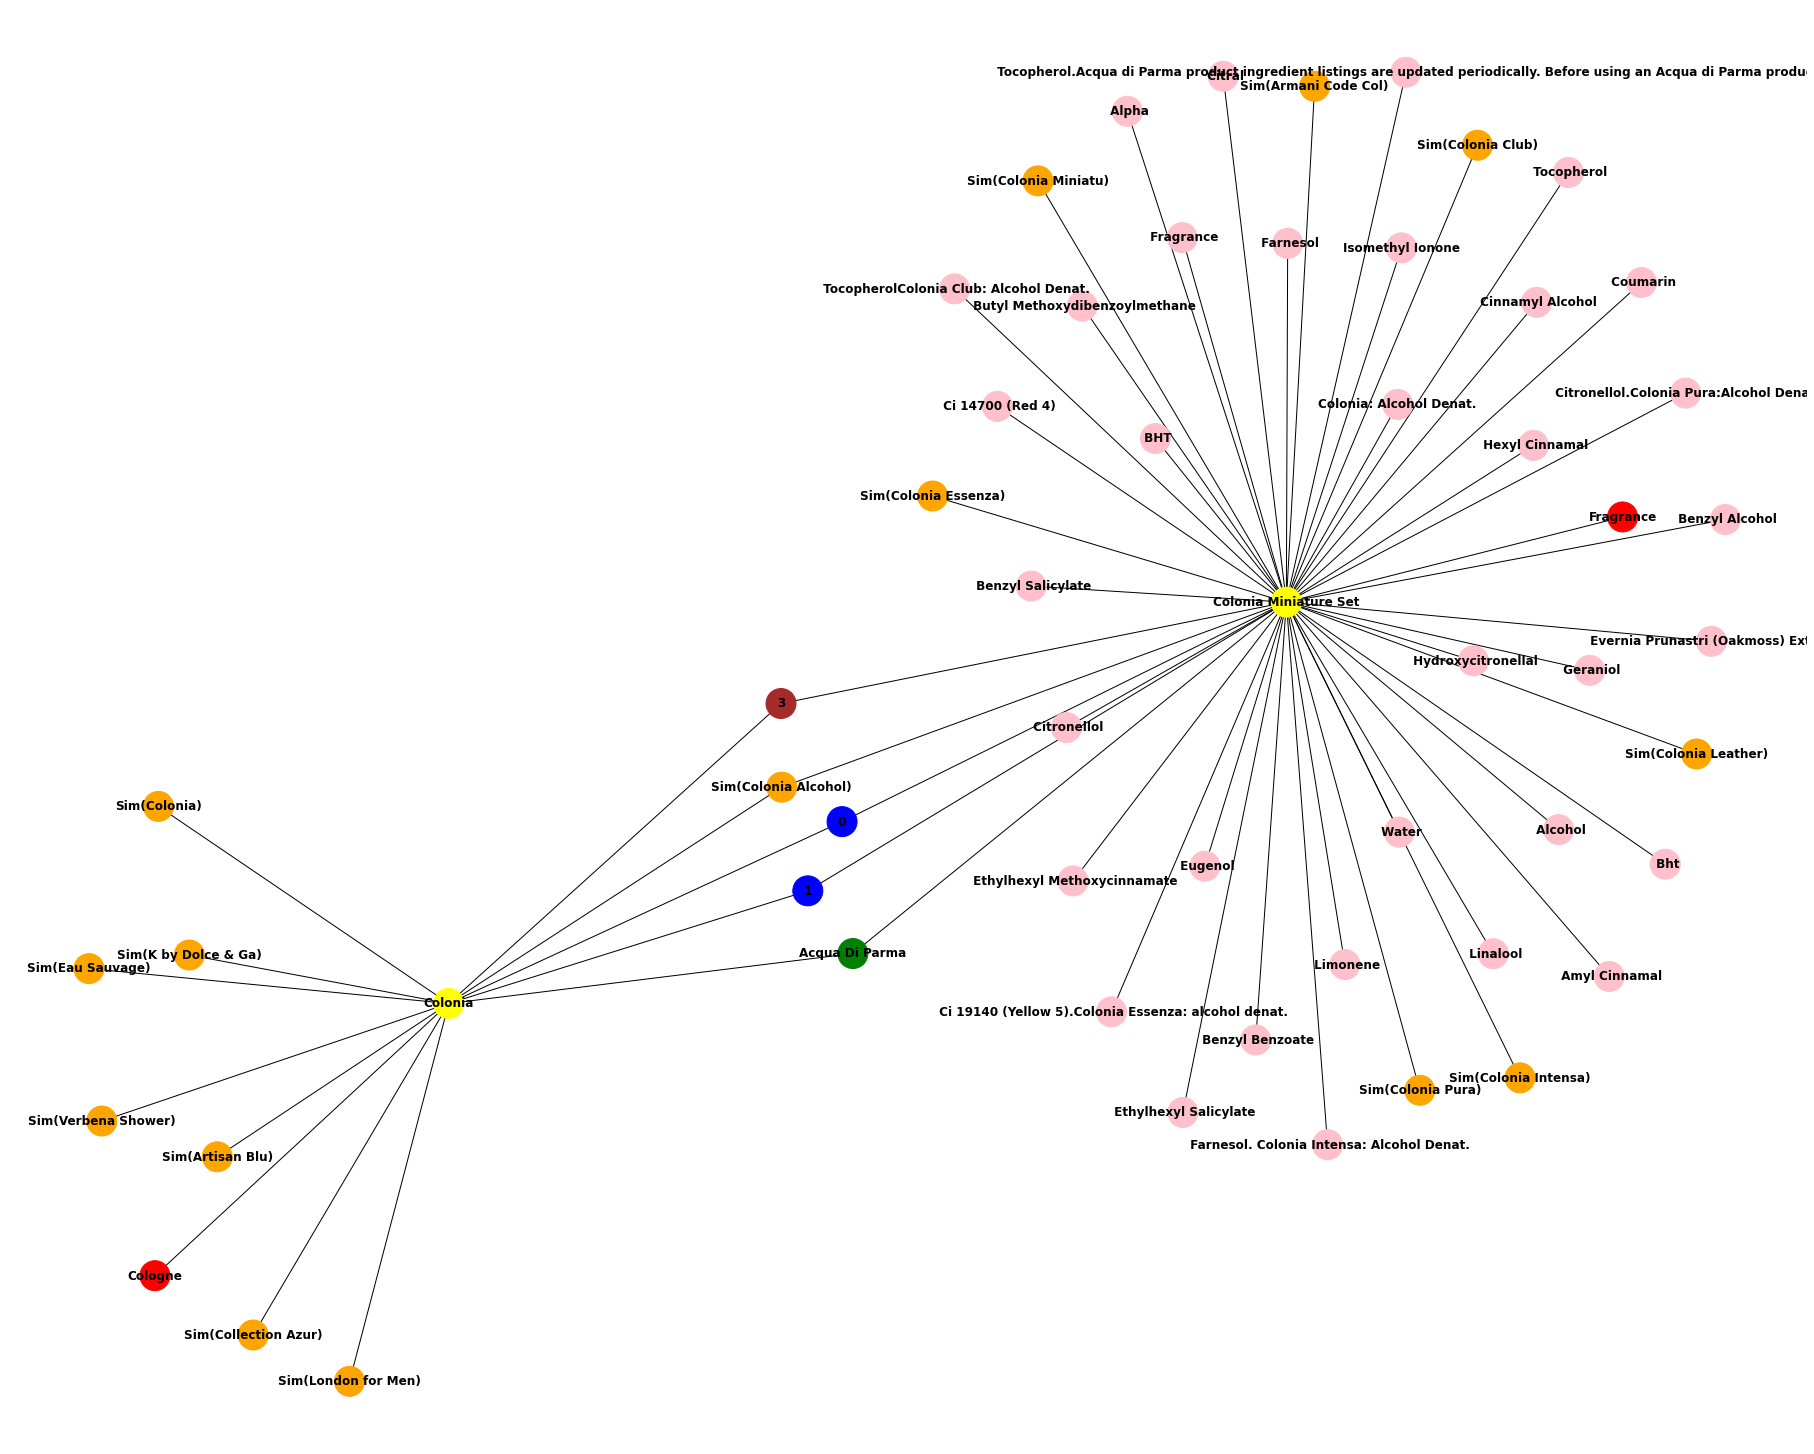

In [25]:
#plot network diagram by testing it with products to view similiarity patterns & what connects the two products together
list_in=["Colonia","Colonia Miniature Set"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

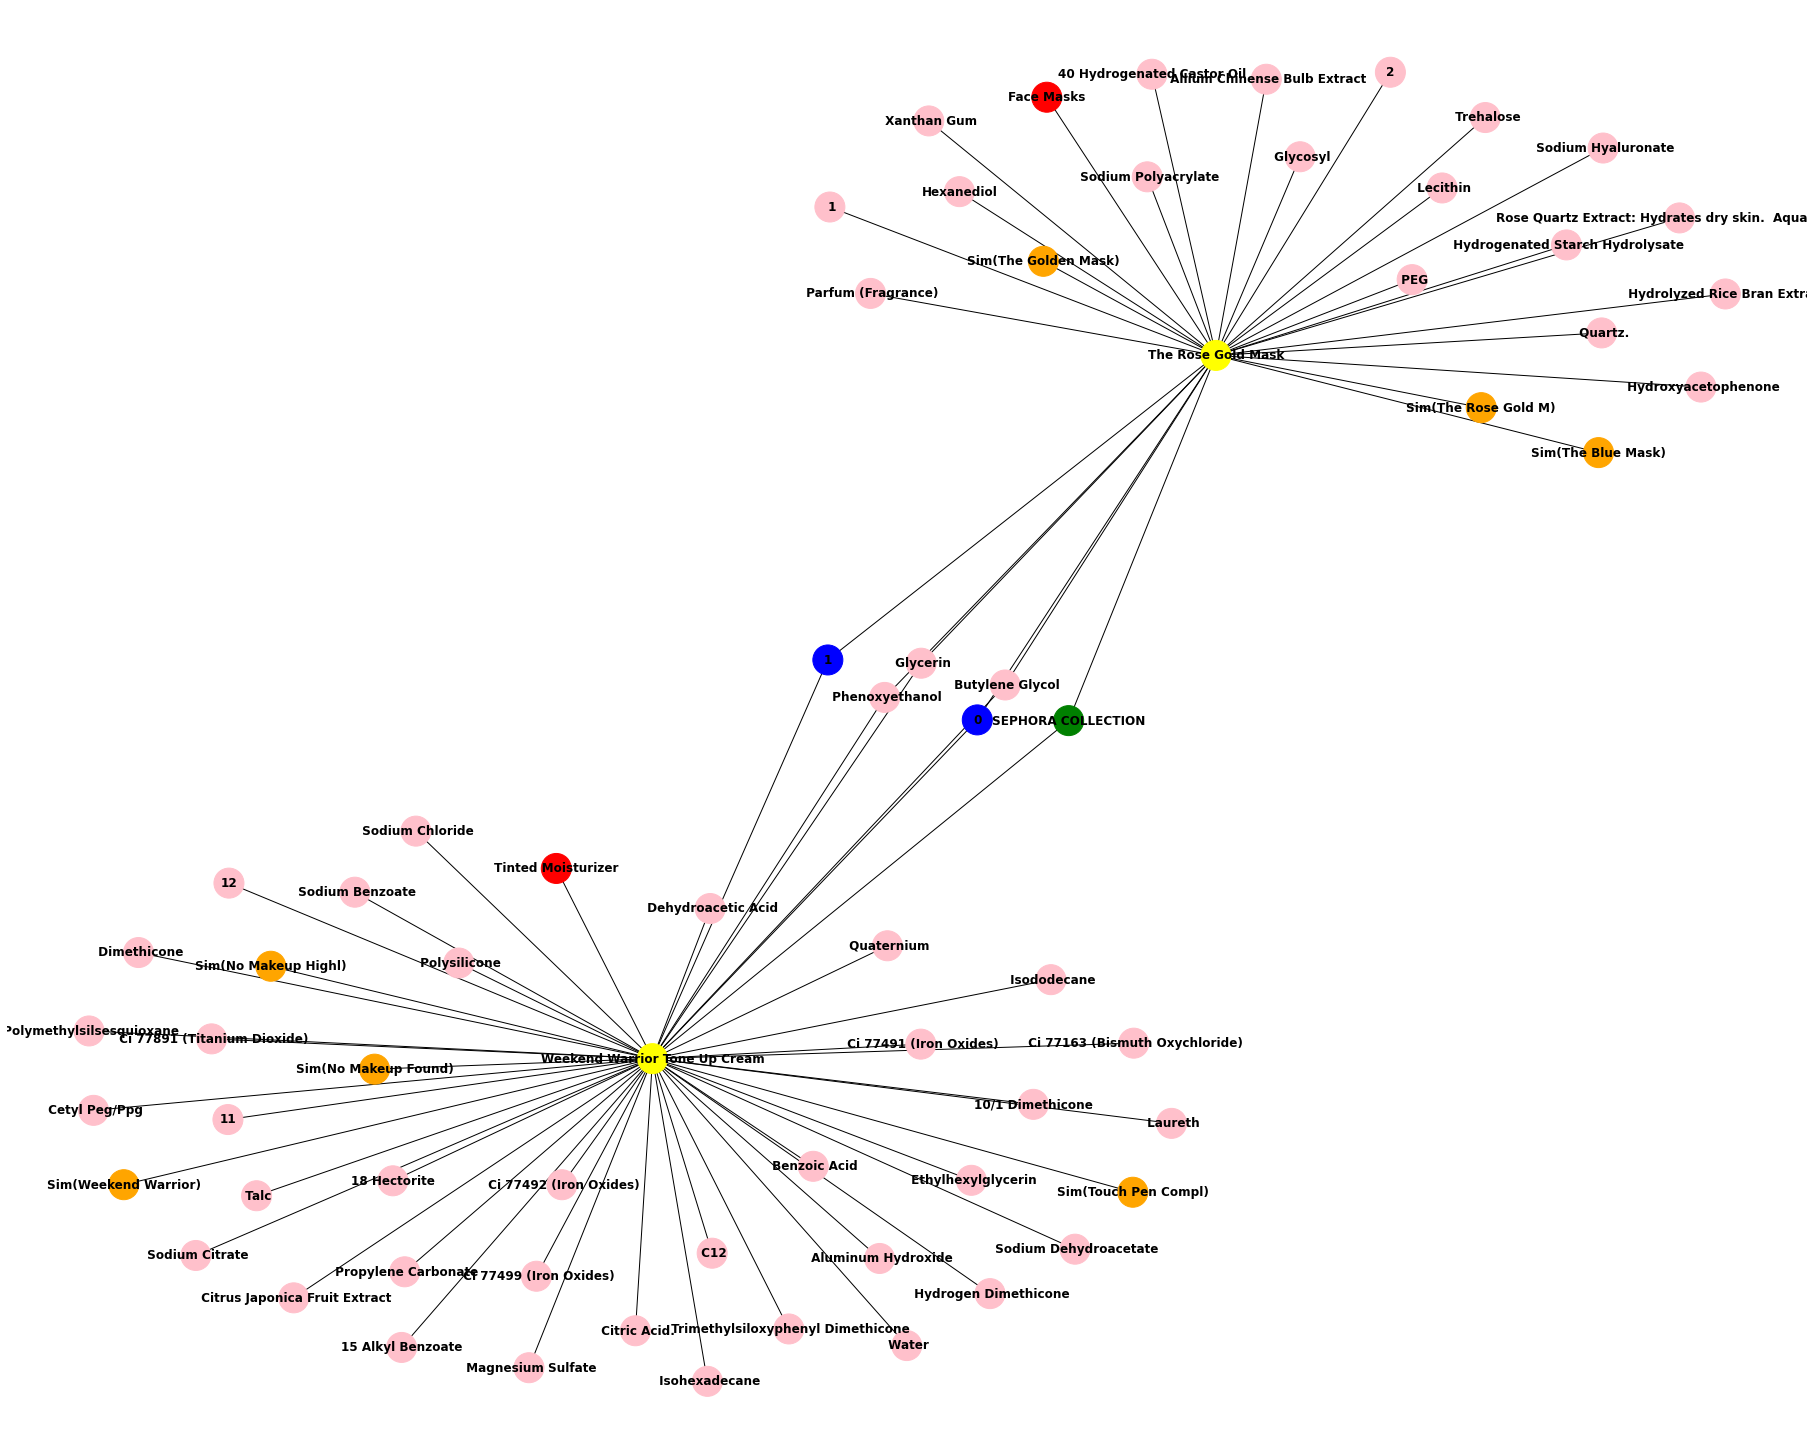

In [26]:
#Let's test out another two products and look at its similiarity 
list_in=["Weekend Warrior Tone Up Cream","The Rose Gold Mask"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

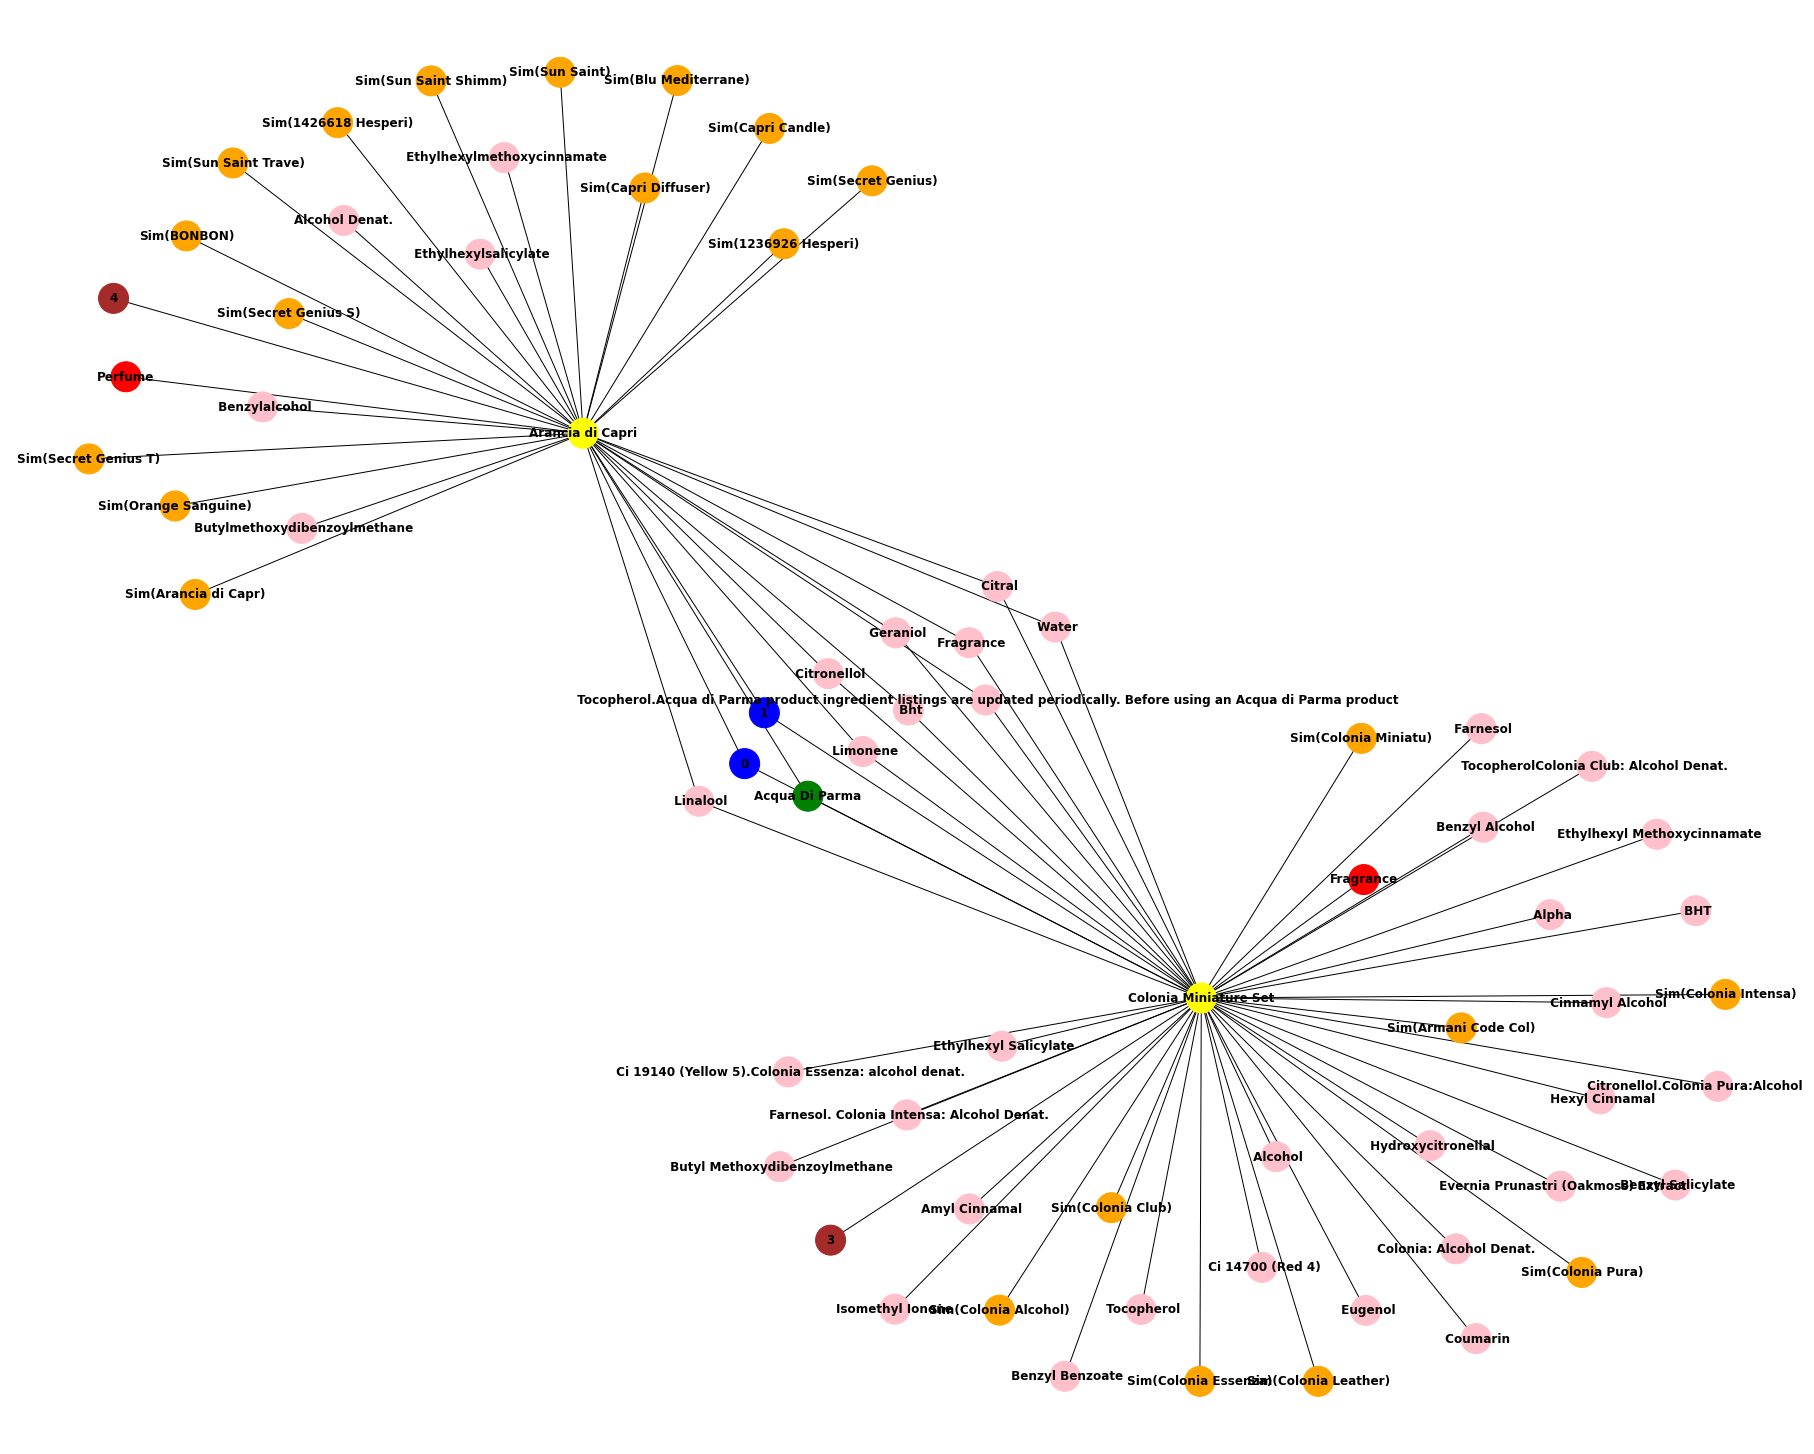

In [27]:


#Let's test out another two products and look at its similiarity 
list_in=["Arancia di Capri","Colonia Miniature Set"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)


In [28]:
#Function to calculate similiarity between 2 products
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="PRODUCTS":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    products=[]
    weight=[]
    ratings=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        products.append(key) 
        weight.append(w)
        ratings.append(sephora.loc[sephora["name"]==key].rating.to_string(index=False))
        
    #ratings = list(np.float_(ratings))
        
    #recommendation = pd.Dataframe(data=np.array(weight),index=products)
    #recommendation = pd.DataFrame(data=np.array(weight),columns=["products","rating"])
    #recommendation.to_frame()
    
    d = {"Name": products, "Closeness": weight, "Rating": ratings}
    recommendation = pd.DataFrame(d)
    recommendation.sort_values(by= ["Closeness"], inplace=True,ascending=False)
    recommendation["Rating"] = pd.to_numeric(recommendation["Rating"])
    recommendation = recommendation[recommendation["Rating"]>= 3.0]
    return recommendation;

In [29]:
#Test the function above by getting recommendations for products
recommendation = get_recommendation("Colonia")
recommendation2 = get_recommendation("The Rose Gold Mask")
recommendation3 = get_recommendation("Weekend Warrior Tone Up Cream")
recommendation4 = get_recommendation("Colonia Miniature Set")
print("*"*40+"\n Recommendation for 'Colonia'\n"+"*"*40)
print(recommendation.head(10))
print("*"*40+"\n Recommendation for 'The Rose Gold Mask'\n"+"*"*40)
print(recommendation2.head(10))
print("*"*40+"\n Recommendation for 'Weekend Warrior Tone Up Cream'\n"+"*"*40)
print(recommendation3.head(10))
print("*"*40+"\n Recommendation for 'Colonia Miniature Set'\n"+"*"*40)
print(recommendation4.head(10))


****************************************
 Recommendation for 'Colonia'
****************************************
                                                   Name  Closeness  Rating
172                      Colonia Alcohol-Free Deodorant   1.622416     3.5
174   Blu Mediterraneo Cipresso di Toscana Travel Spray   1.557575     5.0
19                                       London for Men   1.556542     5.0
115                                            Polo Red   1.359105     5.0
4500                                 Verbena Shower Gel   1.341149     4.5
0                                       Colonia Essenza   1.261832     5.0
159                               Colonia Miniature Set   1.196902     3.5
164                                 Cipresso di Toscana   1.064305     3.5
171                    Fico di Amalfi Spray Body Lotion   0.999465     3.0
137                        Grey Vetiver Eau De Toilette   0.998431     4.5
****************************************
 Recommendation for 'T